In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

### Load in ground truth

In [2]:
images = torch.load('../data/images.pt')
true_counts = torch.load('../data/true_counts.pt')
true_locs = torch.load('../data/true_locs.pt')
true_fluxes = torch.load('../data/true_fluxes.pt')

num_counts = true_counts.max().item() + 1  # |{0,1,2,...,max_count}|

### Load in SMC results

In [3]:
smc_counts = torch.load('smc/counts.pt')
smc_locs = torch.load('smc/locs.pt')
smc_fluxes = torch.load('smc/fluxes.pt')
smc_runtime = torch.load('smc/runtime.pt')
smc_num_iters = torch.load('smc/num_iters.pt')

### Load in SEP results

In [4]:
sep_counts = torch.load('sep/counts.pt')
sep_locs = torch.load('sep/locs.pt')
sep_fluxes = torch.load('sep/fluxes.pt')
sep_runtime = torch.load('sep/runtime.pt')

### Plot attributes

In [5]:
smc_color = "darkblue"
smc_marker = 'o'
sep_color = "darkred"
sep_marker = 's'
fontsize = 16
cmap = 'gray'

---

### Summary statistics across all images

#### SMC

MAE, RMSE, and classification accuracy of posterior mode number of stars (posterior median and mean yield essentially the same results)

In [6]:
(smc_counts.mode(-1).values - true_counts).abs().mean()

tensor(0.2610)

In [7]:
((smc_counts.mode(-1).values - true_counts) ** 2).mean().sqrt()

tensor(0.5450)

In [8]:
(smc_counts.mode(-1).values == true_counts).float().mean()

tensor(0.7570)

MAE and RMSE of posterior mean total flux as a fraction of the prior mean

In [9]:
(smc_fluxes.sum(-1).mean(-1) - true_fluxes.sum(-1)).abs().mean() / 80000

tensor(0.2146)

In [10]:
((smc_fluxes.sum(-1).mean(-1) - true_fluxes.sum(-1)) ** 2).mean().sqrt() / 80000

tensor(0.3591)

Mean and median runtime in seconds

In [11]:
smc_runtime.mean()

tensor(68.8464)

In [12]:
smc_runtime.median()

tensor(65.5056)

Mean and median number of SMC sampler iterations

In [13]:
smc_num_iters.mean()

tensor(23.7370)

In [14]:
smc_num_iters.median()

tensor(23.)

Mean and median number of unique catalogs

In [15]:
device = 'cuda:1'
smc_num_unique = torch.zeros(images.shape[0], device = device)
for i in range(images.shape[0]):
    smc_num_unique[i] = smc_fluxes[i].to(device).unique(dim=0).shape[0]

smc_num_unique = smc_num_unique.to('cpu')

In [16]:
smc_num_unique.mean()

tensor(1831.3790)

In [17]:
smc_num_unique.median()

tensor(1954.)

#### Source Extractor (SEP)

MAE, RMSE, and classification accuracy of estimated number of stars

In [18]:
(sep_counts - true_counts).abs().float().mean()

tensor(1.0400)

In [19]:
((sep_counts - true_counts) ** 2).float().mean().sqrt()

tensor(1.5060)

In [20]:
(sep_counts == true_counts).float().mean()

tensor(0.3780)

MAE and RMSE of estimated total flux as a fraction of the prior mean

In [21]:
(sep_fluxes.sum(-1) - true_fluxes.sum(-1)).abs().mean() / 80000

tensor(0.6266)

In [22]:
((sep_fluxes.sum(-1) - true_fluxes.sum(-1)) ** 2).mean().sqrt() / 80000

tensor(0.8237)

Mean and median runtime in seconds

In [23]:
sep_runtime.mean()

tensor(0.0119)

In [24]:
sep_runtime.median()

tensor(0.0130)

### Plots: Number of stars

In [25]:
smc_est_count_mean = torch.zeros(num_counts)
smc_est_count_q05 = torch.zeros(num_counts)
smc_est_count_q95 = torch.zeros(num_counts)
sep_est_count_mean = torch.zeros(num_counts)
sep_est_count_q05 = torch.zeros(num_counts)
sep_est_count_q95 = torch.zeros(num_counts)

smc_count_mae = torch.zeros(num_counts)
sep_count_mae = torch.zeros(num_counts)

smc_count_accuracy = torch.zeros(num_counts)
sep_count_accuracy = torch.zeros(num_counts)

smc_runtime_mean = torch.zeros(num_counts)
sep_runtime_mean = torch.zeros(num_counts)
smc_num_iters_mean = torch.zeros(num_counts)

for c in range(num_counts):
    smc_est_count_mean[c] = smc_counts[true_counts == c].mode(-1).values.mean()
    smc_est_count_q05[c] = smc_counts[true_counts == c].mode(-1).values.quantile(0.05)
    smc_est_count_q95[c] = smc_counts[true_counts == c].mode(-1).values.quantile(0.95)
    sep_est_count_mean[c] = sep_counts[true_counts == c].mean()
    sep_est_count_q05[c] = sep_counts[true_counts == c].quantile(0.05)
    sep_est_count_q95[c] = sep_counts[true_counts == c].quantile(0.95)
    
    smc_count_mae[c] = (smc_counts.mode(-1).values - true_counts)[true_counts == c].abs().mean()
    sep_count_mae[c] = (sep_counts - true_counts)[true_counts == c].abs().mean()
    
    smc_count_accuracy[c] = (smc_counts.mode(-1).values == true_counts).float()[true_counts == c].mean()
    sep_count_accuracy[c] = (sep_counts == true_counts).float()[true_counts == c].mean()
    
    smc_runtime_mean[c] = smc_runtime[true_counts == c].mean()
    sep_runtime_mean[c] = sep_runtime[true_counts == c].mean()
    smc_num_iters_mean[c] = smc_num_iters[true_counts == c].mean()

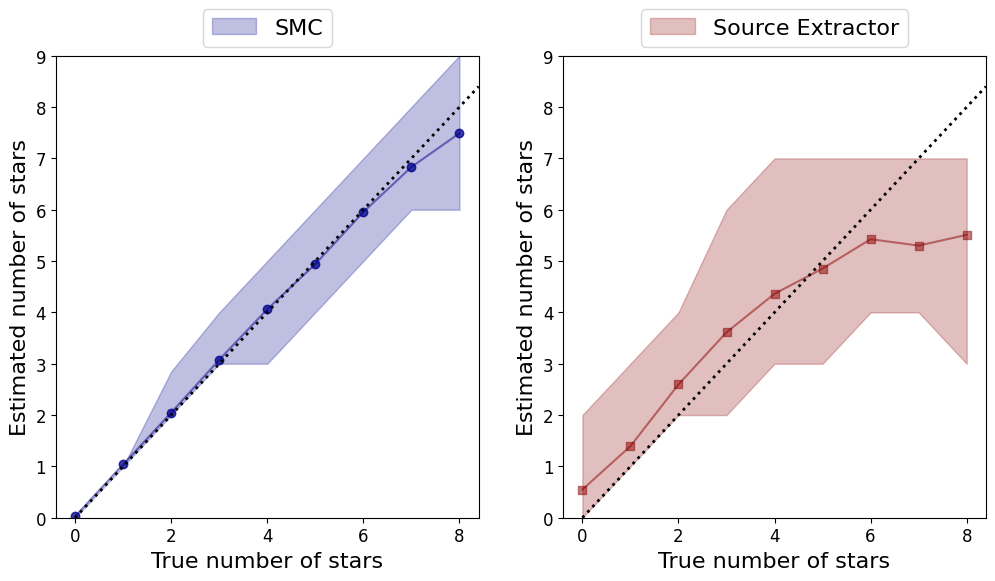

In [26]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))
_ = ax[0].plot(torch.arange(num_counts), smc_est_count_mean,
               color = smc_color, marker = smc_marker, alpha = 0.5)
_ = ax[0].scatter(torch.arange(num_counts), smc_est_count_mean,
                  color = smc_color, alpha = 0.5)
_ = ax[0].fill_between(x = torch.arange(num_counts),
                       y1 = smc_est_count_q05, y2 = smc_est_count_q95,
                       color = smc_color, alpha = 0.25, label = 'SMC')
_ = ax[0].axline((0,0), slope = 1, color = 'black', linestyle = ':', linewidth = 2)
_ = ax[0].legend(fancybox = True, loc = "upper center",
                 bbox_to_anchor = (0.5,1.125), fontsize = fontsize)
_ = ax[0].set_xlabel('True number of stars', fontsize = fontsize)
_ = ax[0].set_ylabel('Estimated number of stars', fontsize = fontsize)
_ = ax[0].tick_params(axis = "both", labelsize = 0.75 * fontsize)
_ = ax[0].set_ylim((0,num_counts))

_ = ax[1].plot(torch.arange(num_counts), sep_est_count_mean,
               color = sep_color, alpha = 0.5)
_ = ax[1].scatter(torch.arange(num_counts), sep_est_count_mean,
                  color = sep_color, marker = sep_marker, alpha = 0.5)
_ = ax[1].fill_between(x = torch.arange(num_counts),
                       y1 = sep_est_count_q05, y2 = sep_est_count_q95,
                       color = sep_color, alpha = 0.25, label = 'Source Extractor')
_ = ax[1].axline((0,0), slope = 1, color = 'black', linestyle = ':', linewidth = 2)
_ = ax[1].legend(fancybox = True, loc = "upper center",
                 bbox_to_anchor = (0.5,1.125), fontsize = fontsize)
_ = ax[1].set_xlabel('True number of stars', fontsize = fontsize)
_ = ax[1].set_ylabel('Estimated number of stars', fontsize = fontsize)
_ = ax[1].tick_params(axis = "both", labelsize = 0.75 * fontsize)
_ = ax[1].set_ylim((0,num_counts))

In [27]:
np.random.seed(1)

num_boot_samples = 10000

smc_mae_bounds = torch.zeros(num_counts, 2)
sep_mae_bounds = torch.zeros(num_counts, 2)

for c in range(num_counts):
    orig = (smc_counts.mode(-1).values - true_counts)[true_counts == c].abs()
    boot_mae = torch.zeros(num_boot_samples)
    
    for j in range(num_boot_samples):
        boot_sample = np.random.choice(orig, size = orig.shape[0], replace = True)
        boot_mae[j] = torch.tensor(boot_sample.mean())
    
    smc_mae_bounds[c] = boot_mae.quantile(torch.tensor((0.05, 0.95)))
    
for c in range(num_counts):
    orig = (sep_counts - true_counts)[true_counts == c].abs()
    boot_mae = torch.zeros(num_boot_samples)
    
    for j in range(num_boot_samples):
        boot_sample = np.random.choice(orig, size = orig.shape[0], replace = True)
        boot_mae[j] = torch.tensor(boot_sample.mean())
    
    sep_mae_bounds[c] = boot_mae.quantile(torch.tensor((0.05, 0.95)))

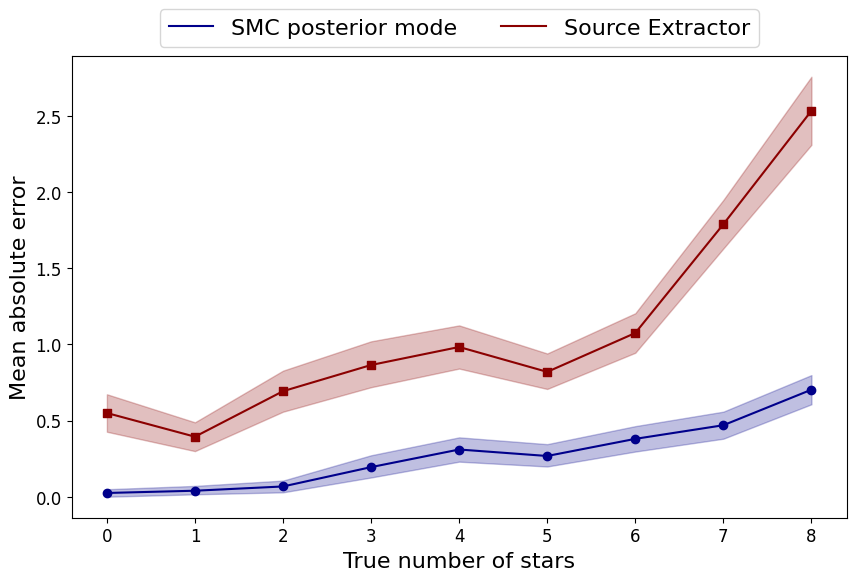

In [28]:
fig, ax = plt.subplots(1, 1, figsize = (10,6))

_ = ax.plot(torch.arange(num_counts), smc_count_mae,
            color = smc_color, label = 'SMC posterior mode')
_ = ax.scatter(torch.arange(num_counts), smc_count_mae,
               color = smc_color, marker = smc_marker)
_ = ax.fill_between(x = torch.arange(num_counts),
                    y1 = smc_mae_bounds[:,0], y2 = smc_mae_bounds[:,1],
                    color = smc_color, alpha = 0.25)

_ = ax.plot(torch.arange(num_counts), sep_count_mae,
            color = sep_color, label = 'Source Extractor')
_ = ax.scatter(torch.arange(num_counts), sep_count_mae,
               color = sep_color, marker = sep_marker)
_ = ax.fill_between(x = torch.arange(num_counts),
                    y1 = sep_mae_bounds[:,0], y2 = sep_mae_bounds[:,1],
                    color = sep_color, alpha = 0.25)

_ = ax.set_xlabel('True number of stars', fontsize = fontsize)
_ = ax.set_ylabel('Mean absolute error', fontsize = fontsize)
_ = ax.tick_params(axis = "both", labelsize = 0.75 * fontsize)
_ = ax.legend(ncol = 2, fancybox = True, loc = "upper center",
              bbox_to_anchor = (0.5,1.125), fontsize = fontsize)

In [29]:
np.random.seed(1)

num_boot_samples = 10000

smc_accuracy_bounds = torch.zeros(num_counts, 2)
sep_accuracy_bounds = torch.zeros(num_counts, 2)

for c in range(num_counts):
    orig = (smc_counts.mode(-1).values == true_counts).float()[true_counts == c]
    boot_accuracy = torch.zeros(num_boot_samples)
    
    for j in range(num_boot_samples):
        boot_sample = np.random.choice(orig, size = orig.shape[0], replace = True)
        boot_accuracy[j] = torch.tensor(boot_sample.mean())
    
    smc_accuracy_bounds[c] = boot_accuracy.quantile(torch.tensor((0.05, 0.95)))
    
for c in range(num_counts):
    orig = (sep_counts == true_counts).float()[true_counts == c]
    boot_accuracy = torch.zeros(num_boot_samples)
    
    for j in range(num_boot_samples):
        boot_sample = np.random.choice(orig, size = orig.shape[0], replace = True)
        boot_accuracy[j] = torch.tensor(boot_sample.mean())
    
    sep_accuracy_bounds[c] = boot_accuracy.quantile(torch.tensor((0.05, 0.95)))

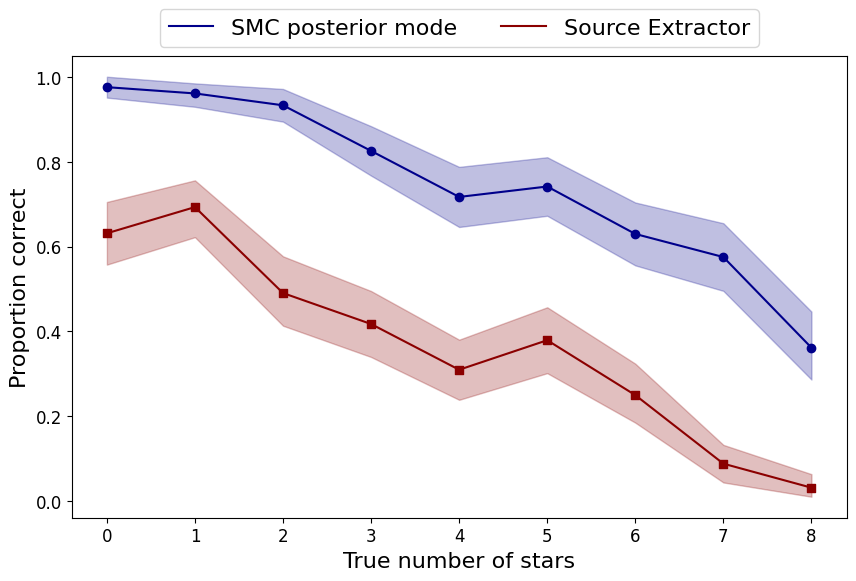

In [30]:
fig, ax = plt.subplots(1, 1, figsize = (10,6))

_ = ax.plot(torch.arange(num_counts), smc_count_accuracy,
            color = smc_color, label = 'SMC posterior mode')
_ = ax.scatter(torch.arange(num_counts), smc_count_accuracy,
               color = smc_color, marker = smc_marker)
_ = ax.fill_between(x = torch.arange(num_counts),
                    y1 = smc_accuracy_bounds[:,0], y2 = smc_accuracy_bounds[:,1],
                    color = smc_color, alpha = 0.25)

_ = ax.plot(torch.arange(num_counts), sep_count_accuracy,
            color = sep_color, label = 'Source Extractor')
_ = ax.scatter(torch.arange(num_counts), sep_count_accuracy,
               color = sep_color, marker = sep_marker)
_ = ax.fill_between(x = torch.arange(num_counts),
                    y1 = sep_accuracy_bounds[:,0], y2 = sep_accuracy_bounds[:,1],
                    color = sep_color, alpha = 0.25)

_ = ax.legend(ncol = 2, fancybox = True, loc = "upper center",
              bbox_to_anchor = (0.5,1.125), fontsize = fontsize)
_ = ax.set_xlabel('True number of stars', fontsize = fontsize)
_ = ax.set_ylabel('Proportion correct', fontsize = fontsize)
_ = ax.tick_params(axis = "both", labelsize = 0.75 * fontsize)

### Plots: Total flux

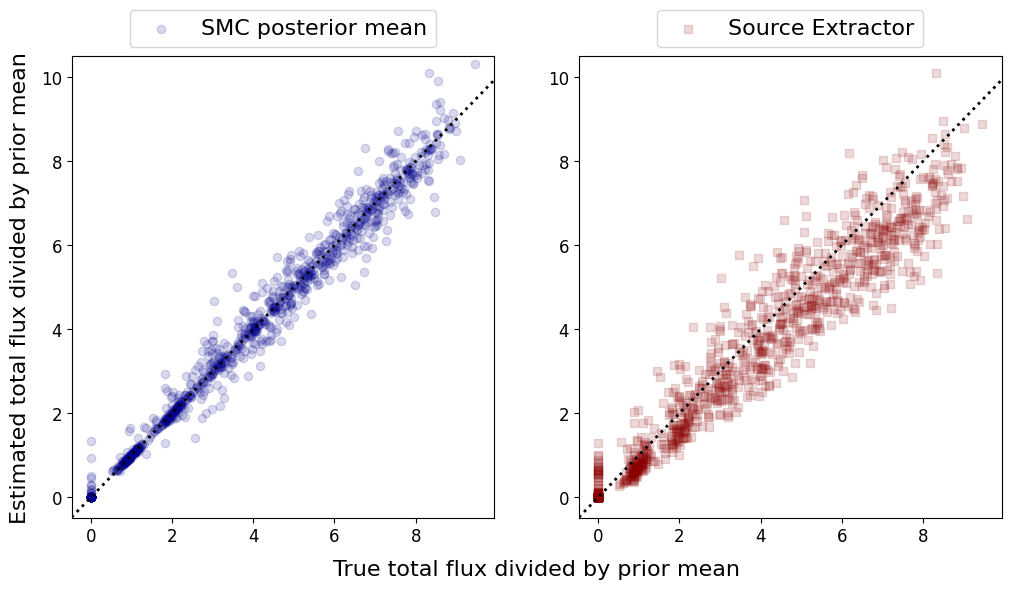

In [31]:
fig, ax = plt.subplots(1, 2, figsize = (12,6))

_ = ax[0].scatter(x = true_fluxes.sum(-1) / 80000, y = smc_fluxes.sum(-1).mean(-1) / 80000,
                  color = smc_color, marker = smc_marker, alpha = 0.15, label = 'SMC posterior mean')
_ = ax[0].axline((0,0), slope = 1, color = 'black', linestyle = ':', linewidth = 2)
_ = ax[0].legend(fancybox = True, loc = "upper center",
                 bbox_to_anchor = (0.5, 1.125), fontsize = fontsize)
_ = ax[0].tick_params(axis = "both", labelsize = 0.75 * fontsize)
_ = ax[0].set_ylim((-0.5, 10.5))

_ = ax[1].scatter(x = true_fluxes.sum(-1) / 80000, y = sep_fluxes.sum(-1) / 80000,
                  color = sep_color, marker = sep_marker, alpha = 0.15, label = "Source Extractor")
_ = ax[1].axline((0,0), slope = 1, color = 'black', linestyle = ':', linewidth = 2)
_ = ax[1].legend(fancybox = True, loc = "upper center",
                 bbox_to_anchor = (0.5, 1.125), fontsize = fontsize)
_ = ax[1].tick_params(axis = "both", labelsize = 0.75 * fontsize)
_ = ax[1].set_ylim((-0.5, 10.5))

_ = labels = fig.add_subplot(111, frameon = False)
_ = labels.set_xlabel('True total flux divided by prior mean', labelpad = 30, fontsize = fontsize)
_ = labels.set_ylabel('Estimated total flux divided by prior mean', labelpad = 30, fontsize = fontsize)
_ = labels.set_xticks([])
_ = labels.set_yticks([])

In [32]:
interval = 0.90
q05 = smc_fluxes.sum(-1).quantile(0.5 - interval / 2, dim = -1)
q95 = smc_fluxes.sum(-1).quantile(0.5 + interval / 2, dim = -1)
covered = torch.logical_and(q05 <= true_fluxes.sum(-1),
                            q95 >= true_fluxes.sum(-1))

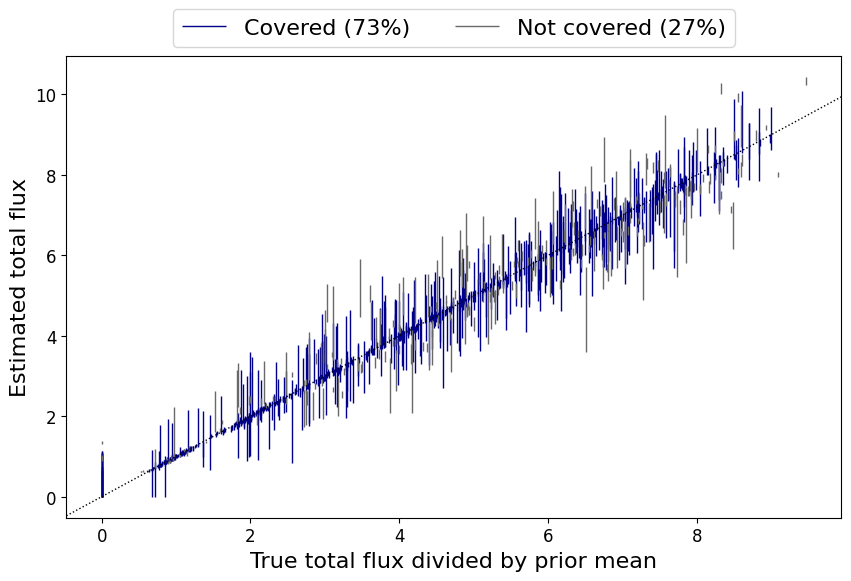

In [33]:
fig, ax = plt.subplots(1, 1, figsize = (10,6))

_ = ax.vlines(x = true_fluxes.sum(-1)[covered] / 80000,
              ymin = q05[covered] / 80000, ymax = q95[covered] / 80000,
              color = smc_color, alpha = 1, linewidth = 1,
              label = f'Covered ({(covered.float().mean() * 100).round().int()}%)')
_ = ax.vlines(x = true_fluxes.sum(-1)[~covered] / 80000,
              ymin = q05[~covered] / 80000, ymax = q95[~covered] / 80000,
              color = 'dimgray', alpha = 1, linewidth = 1,
              label = f'Not covered ({((~covered).float().mean() * 100).round().int()}%)')
_ = ax.axline((0,0), slope = 1, color = 'black', linestyle = ':', linewidth = 1)

_ = ax.legend(ncol = 2, fancybox = True, loc = "upper center",
              bbox_to_anchor = (0.5,1.125), fontsize = fontsize)
_ = ax.set_xlabel('True total flux divided by prior mean', fontsize = fontsize)
_ = ax.set_ylabel('Estimated total flux', fontsize = fontsize)
_ = ax.tick_params(axis = "both", labelsize = 0.75 * fontsize)

### Plots: Runtime and number of iterations

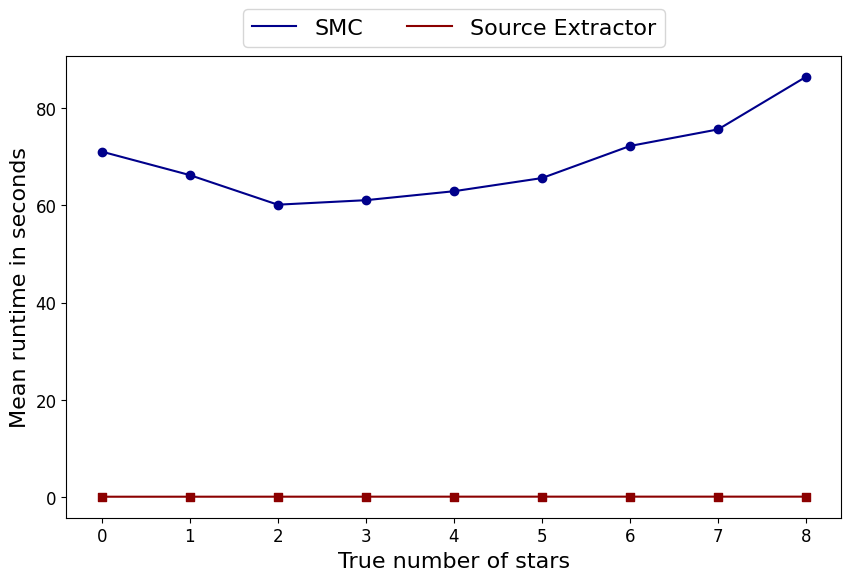

In [34]:
fig, ax = plt.subplots(1, 1, figsize = (10,6))

_ = ax.plot(torch.arange(num_counts), smc_runtime_mean,
            color = smc_color, label = 'SMC')
_ = ax.scatter(torch.arange(num_counts), smc_runtime_mean,
               color = smc_color, marker = smc_marker)

_ = ax.plot(torch.arange(num_counts), sep_runtime_mean,
            color = sep_color, label = 'Source Extractor')
_ = ax.scatter(torch.arange(num_counts), sep_runtime_mean,
               color = sep_color, marker = sep_marker)

_ = ax.set_xlabel('True number of stars', fontsize = fontsize)
_ = ax.set_ylabel('Mean runtime in seconds', fontsize = fontsize)
_ = ax.legend(ncol = 2, fancybox = True, loc = "upper center",
              bbox_to_anchor = (0.5,1.125), fontsize = fontsize)
_ = ax.tick_params(axis = "both", labelsize = 0.75 * fontsize)

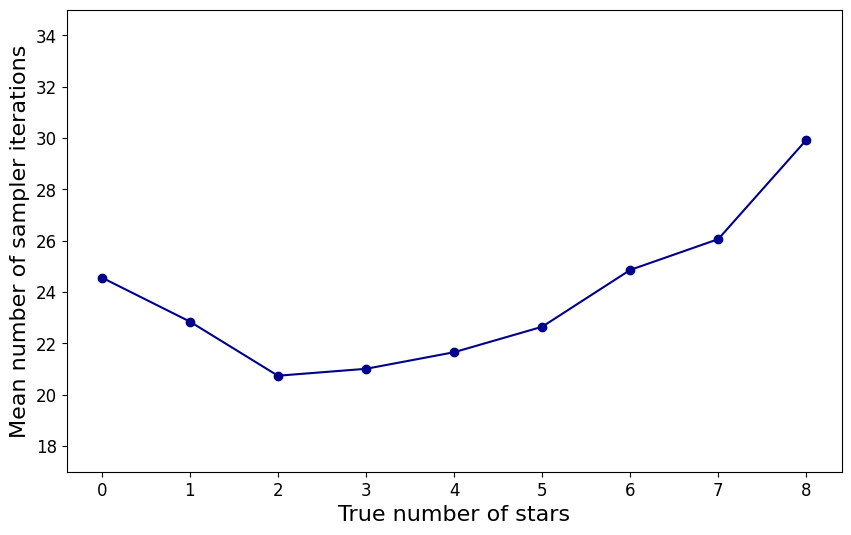

In [35]:
fig, ax = plt.subplots(1, 1, figsize = (10,6))

_ = ax.plot(torch.arange(num_counts), smc_num_iters_mean, color = smc_color)
_ = ax.scatter(torch.arange(num_counts), smc_num_iters_mean,
               color = smc_color, marker = smc_marker)

_ = ax.set_xlabel('True number of stars', fontsize = fontsize)
_ = ax.set_ylabel('Mean number of sampler iterations', fontsize = fontsize)
_ = ax.tick_params(axis = "both", labelsize = 0.75 * fontsize)
_ = ax.set_ylim((17,35))

### Plots: Reconstructed images

In [36]:
import sys
sys.path.append('../../..')
from smc.images import ImageModel

imagemodel = ImageModel(image_height = images.shape[1],
                        image_width = images.shape[2],
                        psf_stdev = 1.5,
                        background = 100000)

In [37]:
def plot_detections(image_index, smc_catalog_index):
    fig, ax = plt.subplots(1, 3, figsize = (15,6), layout = 'compressed')

    orig = ax[0].imshow(images[image_index], cmap = cmap)
    _ = ax[0].scatter(true_locs[image_index, :true_counts[image_index].item(), 1] - 0.5,
                    true_locs[image_index, :true_counts[image_index].item(), 0] - 0.5,
                    color = 'gold', edgecolors = 'black', marker = '*', s = 200)
    _ = ax[0].set_title('Image')
    _ = ax[0].set_xticks([])
    _ = ax[0].set_yticks([])

    smc_psf = imagemodel.psf(smc_locs[image_index,smc_catalog_index,:].view(1,1,1,-1,2))
    smc_rate = (smc_psf * smc_fluxes[image_index,smc_catalog_index,:].view(1,1,1,1,1,-1)).sum(-1) + imagemodel.background
    smc_reconstruction = smc_rate.squeeze([0,1]).permute((2,0,1)).squeeze()
    smc_recon = ax[1].imshow(smc_reconstruction, cmap = cmap)
    _ = ax[1].scatter(smc_locs[image_index, smc_catalog_index, :smc_counts[image_index, smc_catalog_index].int().item(), 1] - 0.5,
                      smc_locs[image_index, smc_catalog_index, :smc_counts[image_index, smc_catalog_index].int().item(), 0] - 0.5,
                      color = 'blue', edgecolors = 'black', marker = '*', s = 200)
    _ = ax[1].set_title('SMC reconstruction')
    _ = ax[1].set_xticks([])
    _ = ax[1].set_yticks([])

    sep_psf = imagemodel.psf(sep_locs[image_index, :].view(1,1,1,-1,2))
    sep_rate = (sep_psf * sep_fluxes[image_index,:].view(1,1,1,1,1,-1)).sum(-1) + imagemodel.background
    sep_reconstruction = sep_rate.squeeze([0,1]).permute((2,0,1)).squeeze()
    sep_recon = ax[2].imshow(sep_reconstruction, cmap = cmap)
    _ = ax[2].scatter(sep_locs[image_index, :sep_counts[image_index].int().item(), 1] - 0.5,
                      sep_locs[image_index, :sep_counts[image_index].int().item(), 0] - 0.5,
                      color = 'red', edgecolors = 'black', marker = '*', s = 200)
    _ = ax[2].set_title('Source Extractor reconstruction')
    _ = ax[2].set_xticks([])
    _ = ax[2].set_yticks([])

    plt.colorbar(sep_recon, ax = ax, fraction = 0.045)

In [38]:
np.random.seed(1)

image_indexes = torch.zeros(num_counts, 2)

for c in range(num_counts):
    image_indexes[c] = torch.tensor(np.random.choice(torch.logical_and(true_counts == c,
                                                                       smc_counts.std(-1) > 0.25).nonzero().squeeze(),
                                                     size = 2, replace = False))

image_indexes = image_indexes.int()

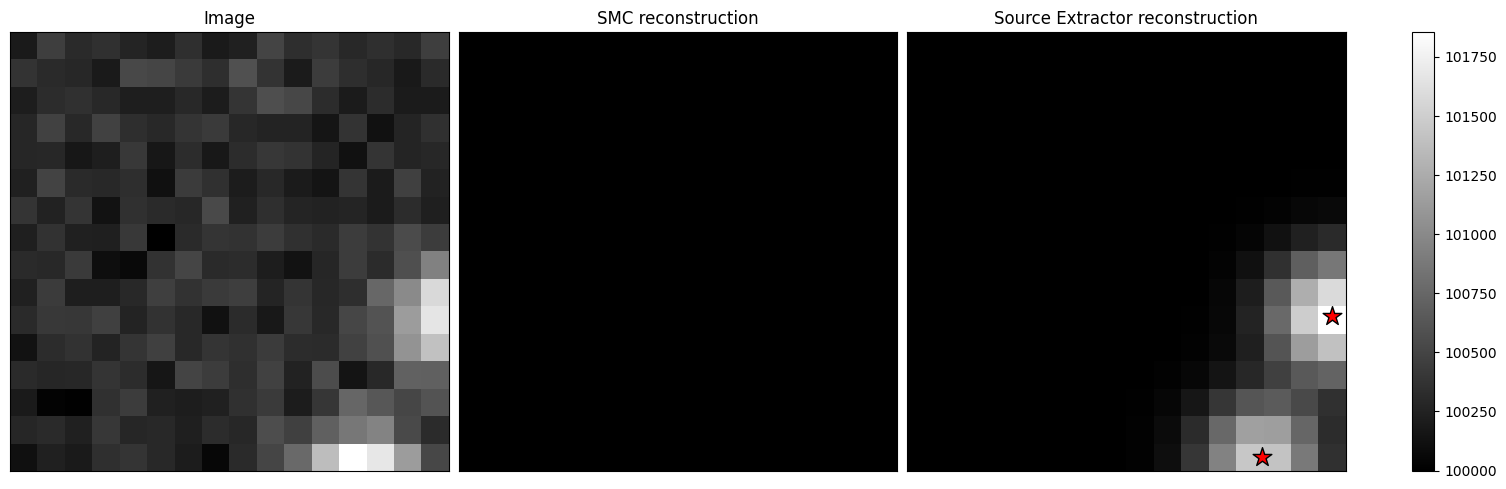

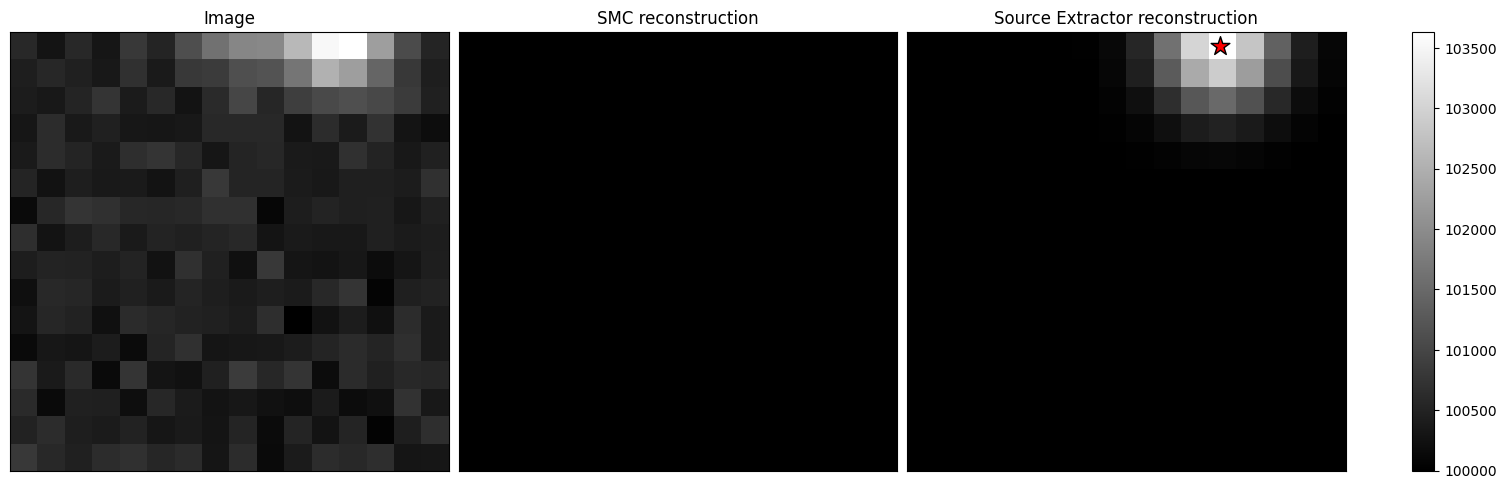

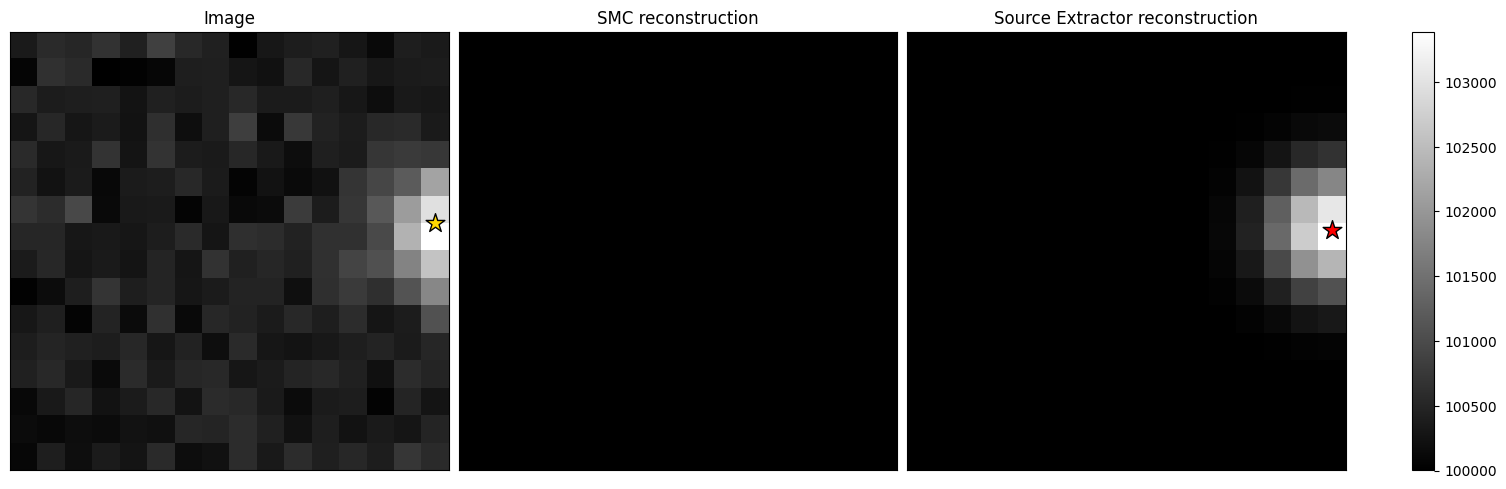

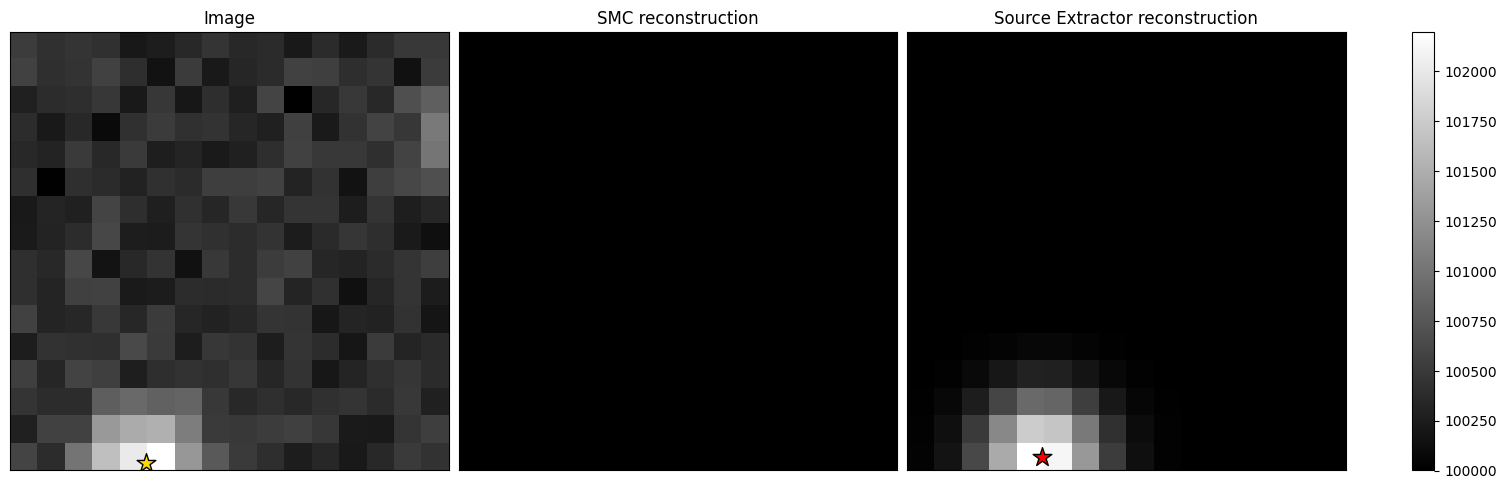

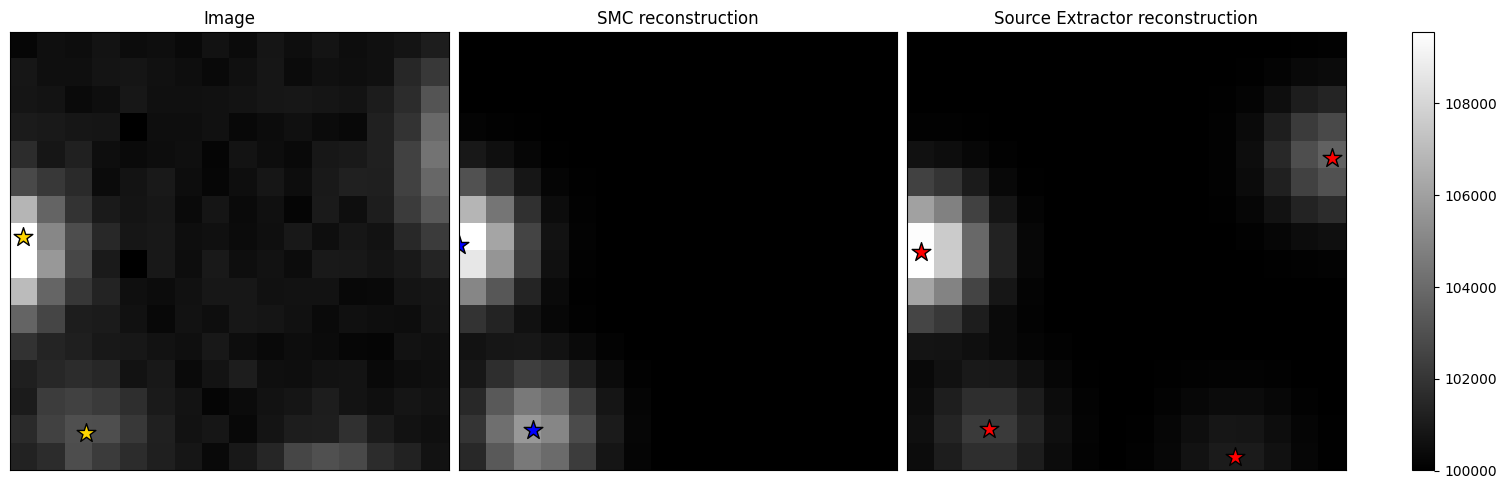

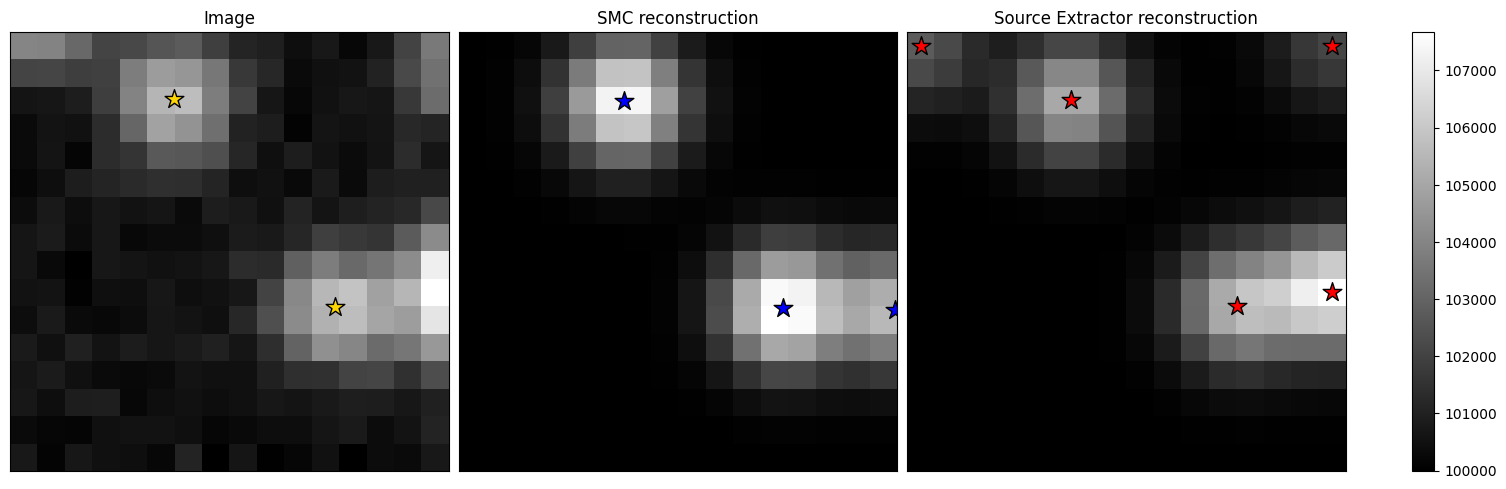

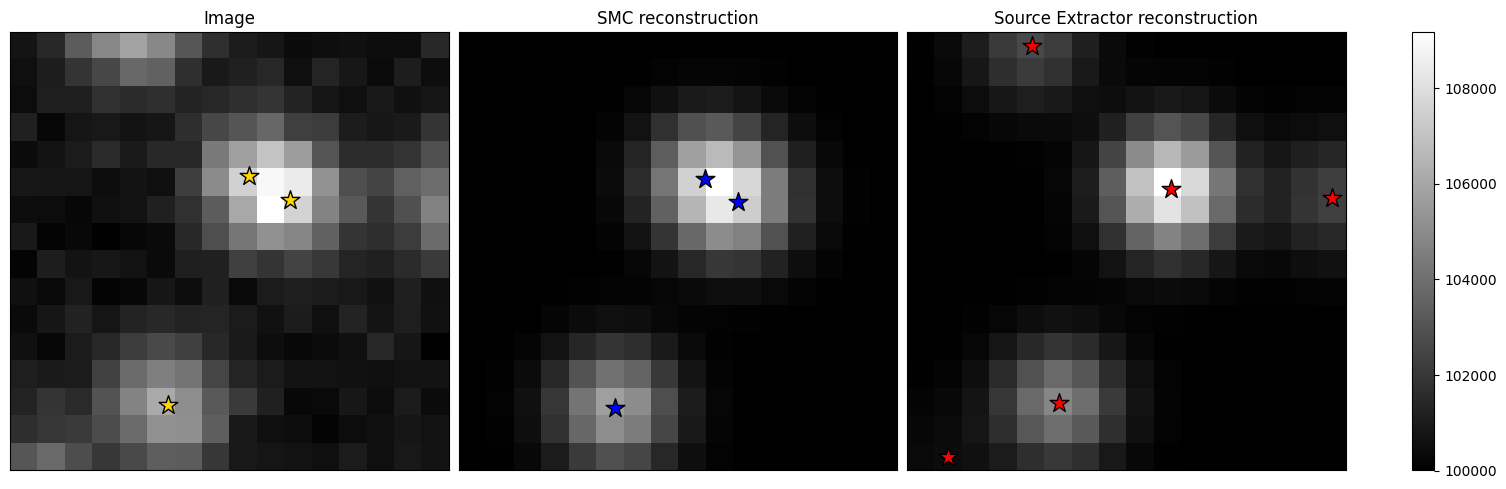

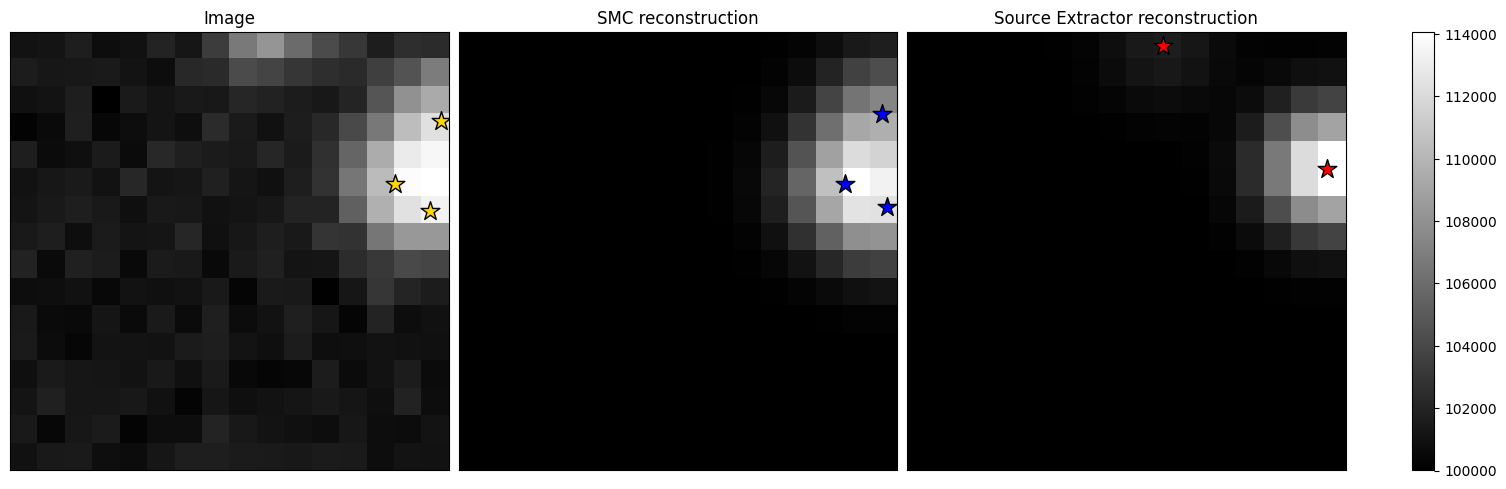

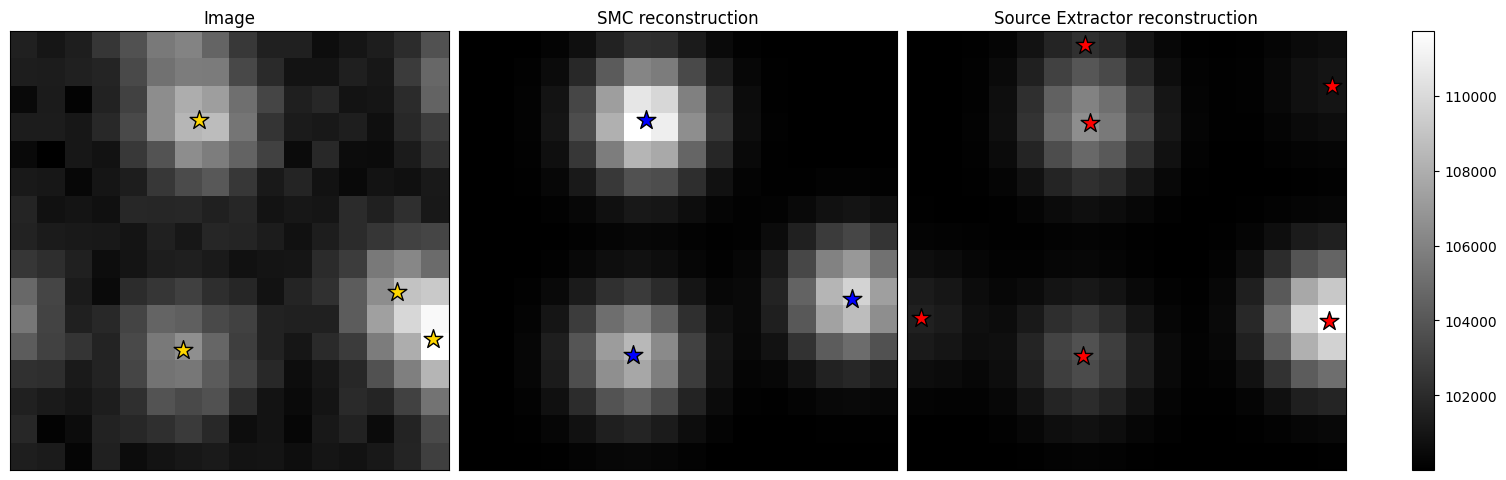

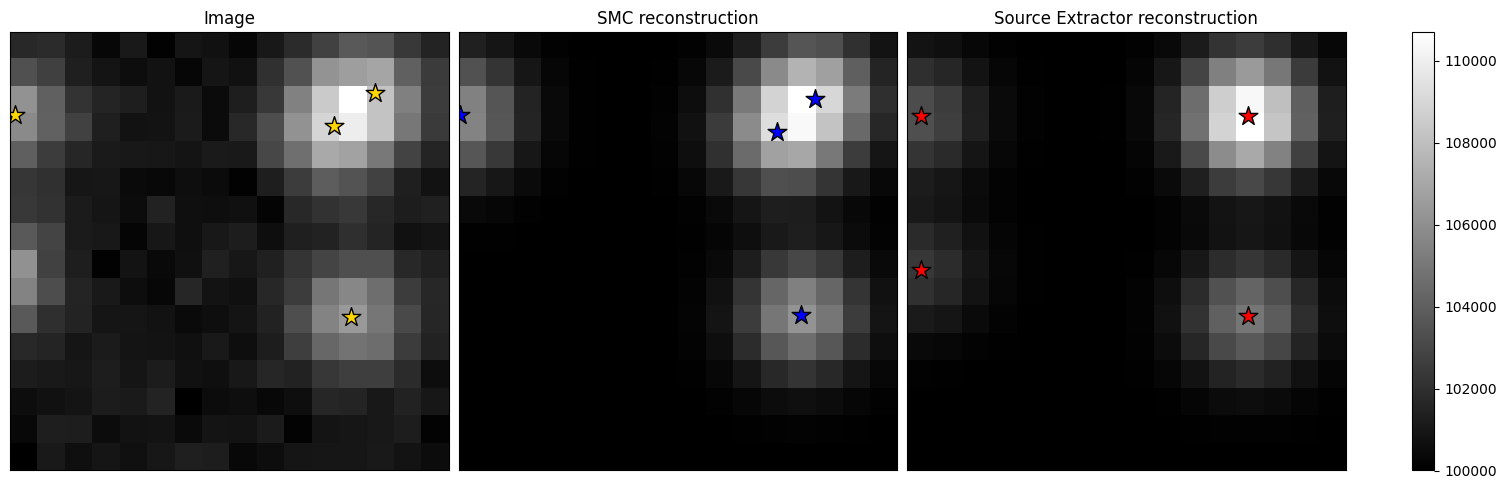

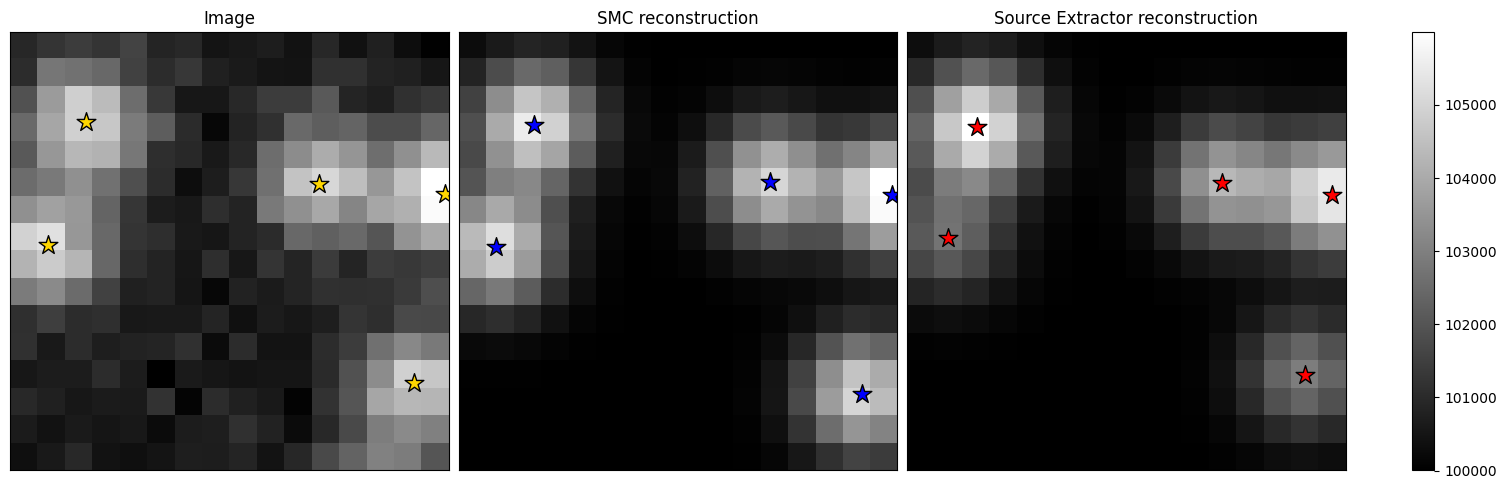

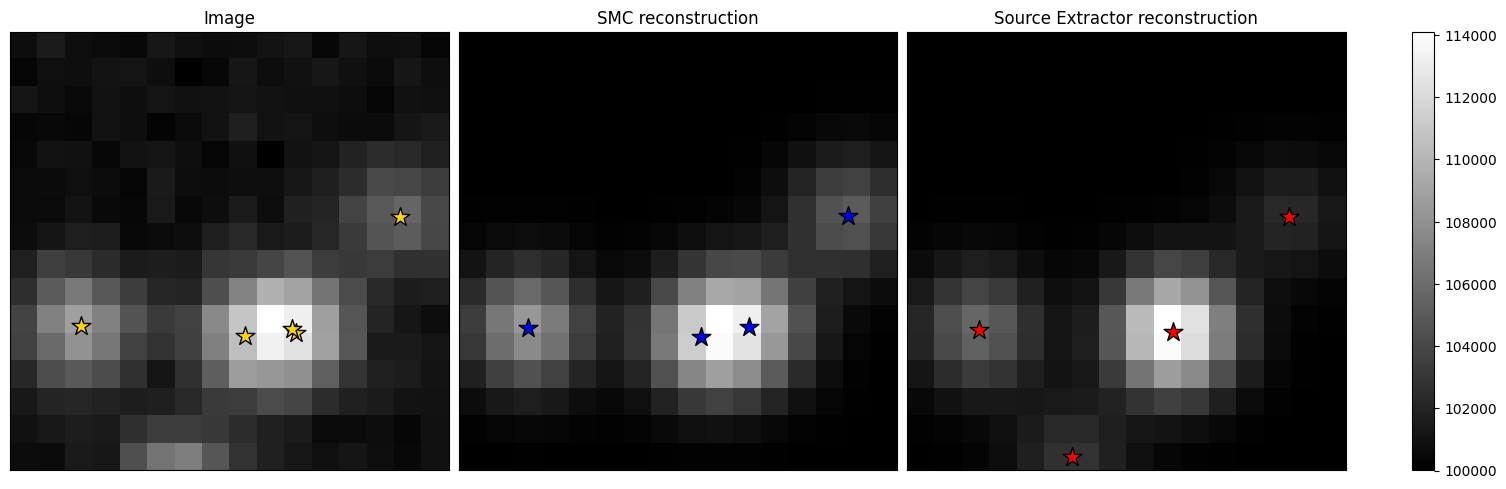

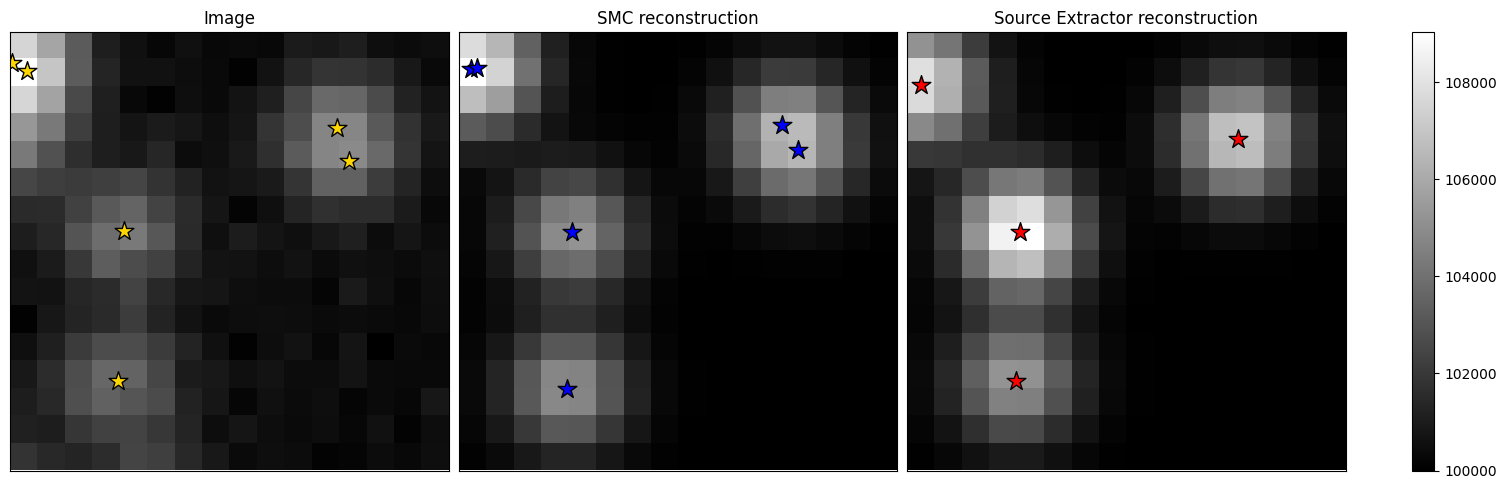

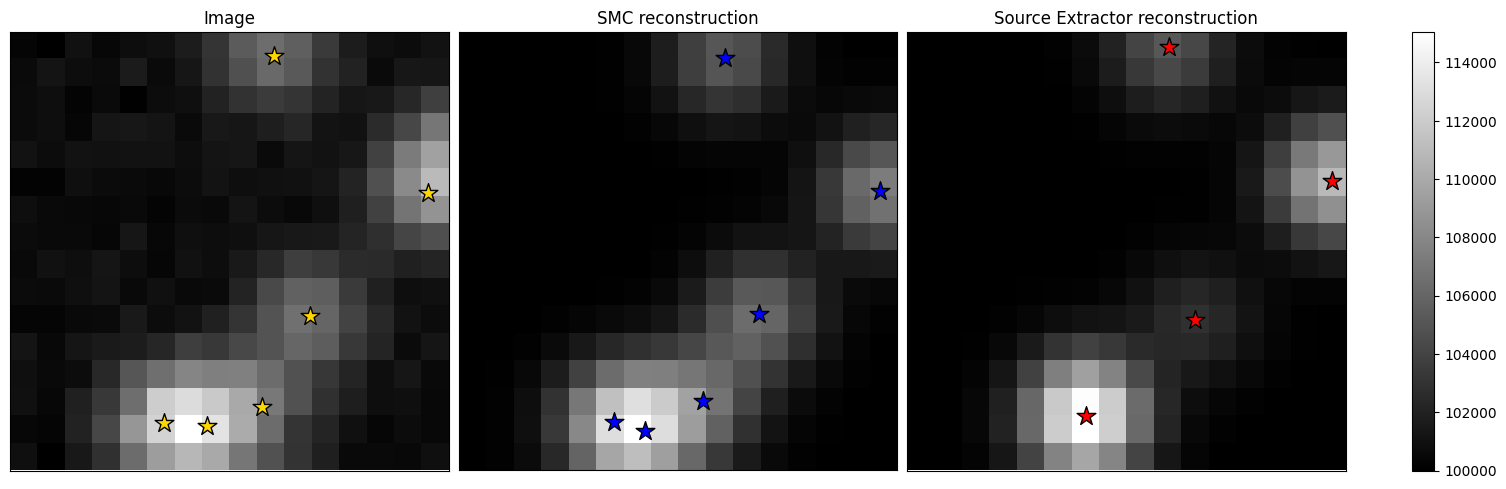

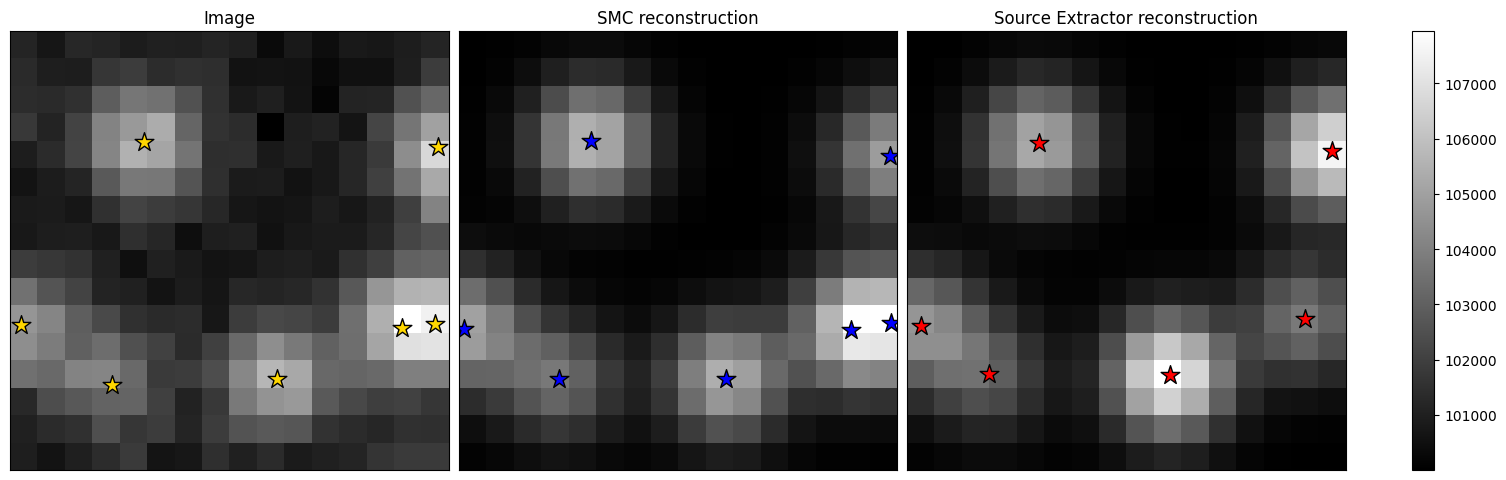

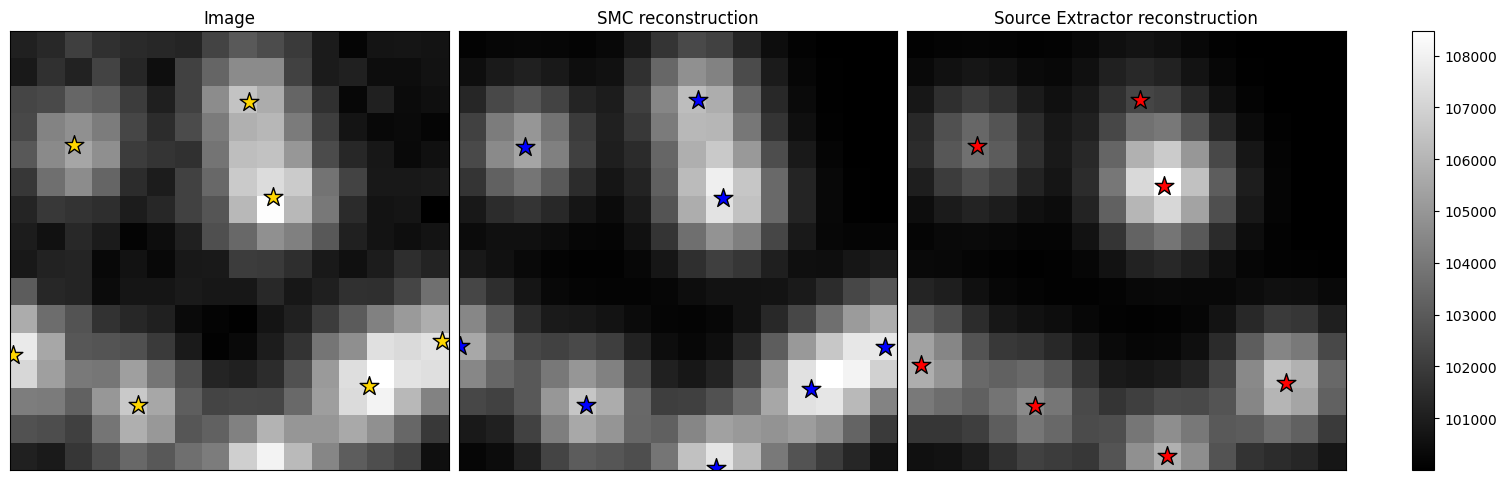

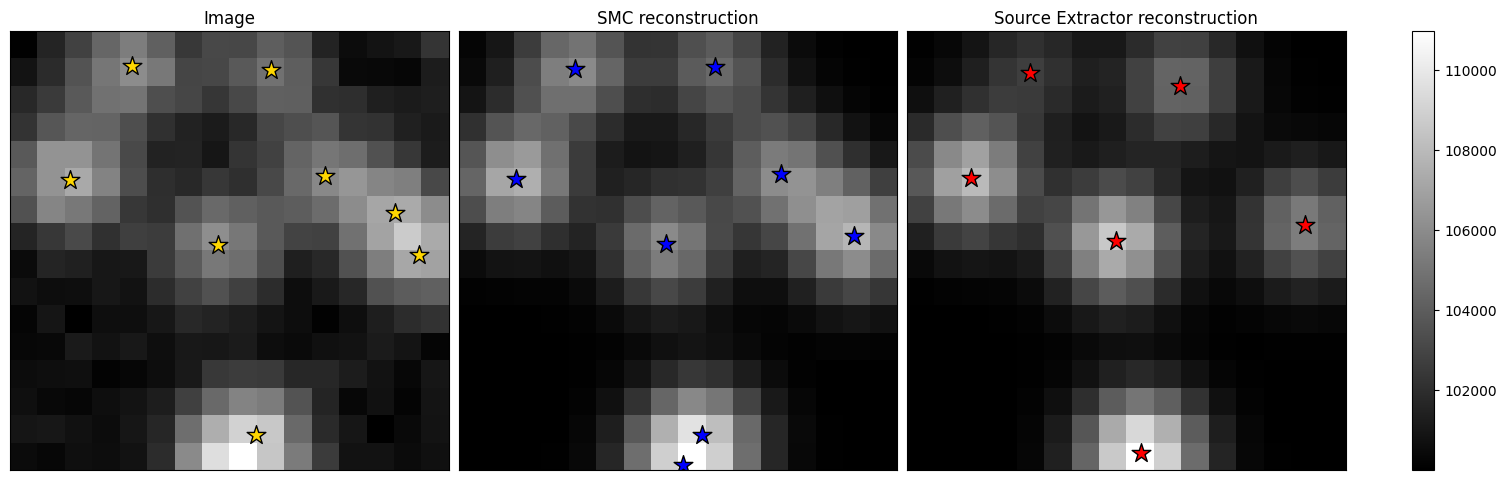

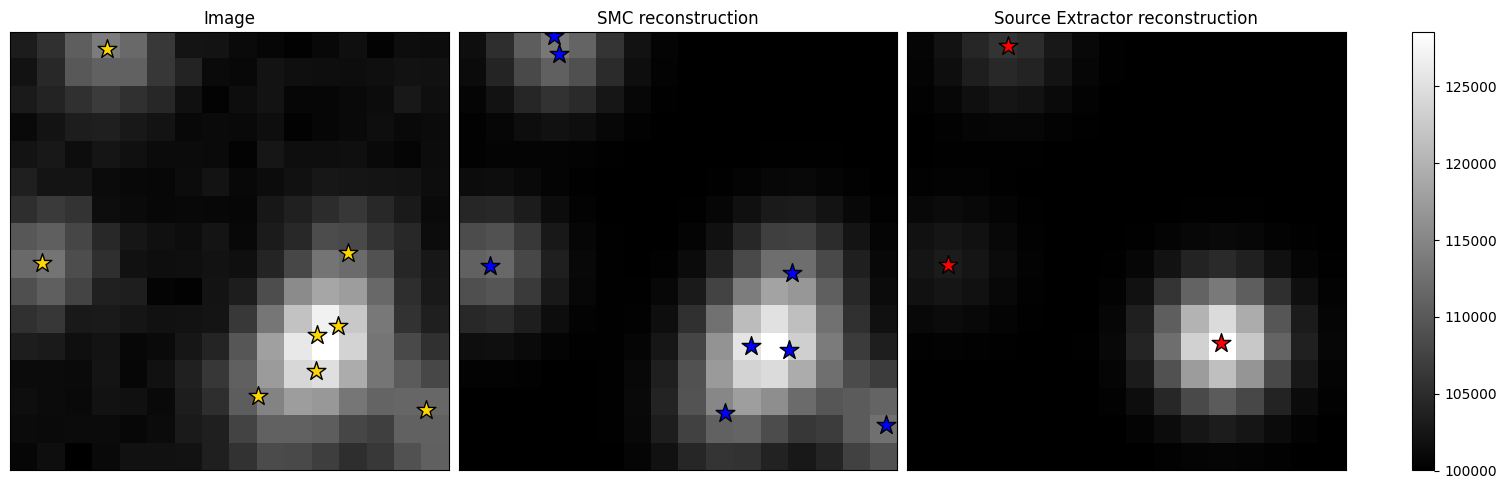

In [39]:
for c in range(num_counts):
    unique, num = smc_fluxes[image_indexes[c,0]].unique(dim = 0, return_counts = True)
    cat1 = unique[num.topk(k = 1).indices]
    cat_index = (smc_fluxes[image_indexes[c,0]] == cat1).all(dim = 1).nonzero()[0].item()
    plot_detections(image_indexes[c,0], cat_index)
    
    unique, num = smc_fluxes[image_indexes[c,1]].unique(dim = 0, return_counts = True)
    cat1 = unique[num.topk(k = 1).indices]
    cat_index = (smc_fluxes[image_indexes[c,1]] == cat1).all(dim = 1).nonzero()[0].item()
    plot_detections(image_indexes[c,1], cat_index)